<h2>HUXt examples.</h2>

This notebook contains several examples of how to use the 1D and 2D versions of HUXt provided is this package, as described in Owens et al (2020).

In [2]:
import numpy as np
import HUXt as H
import astropy.units as u
import matplotlib.pyplot as plt

(<Figure size 1008x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c201cca748>)

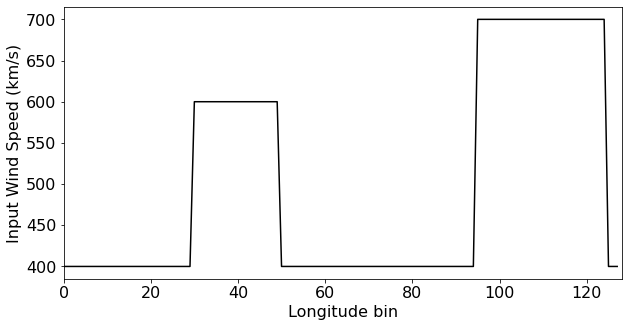

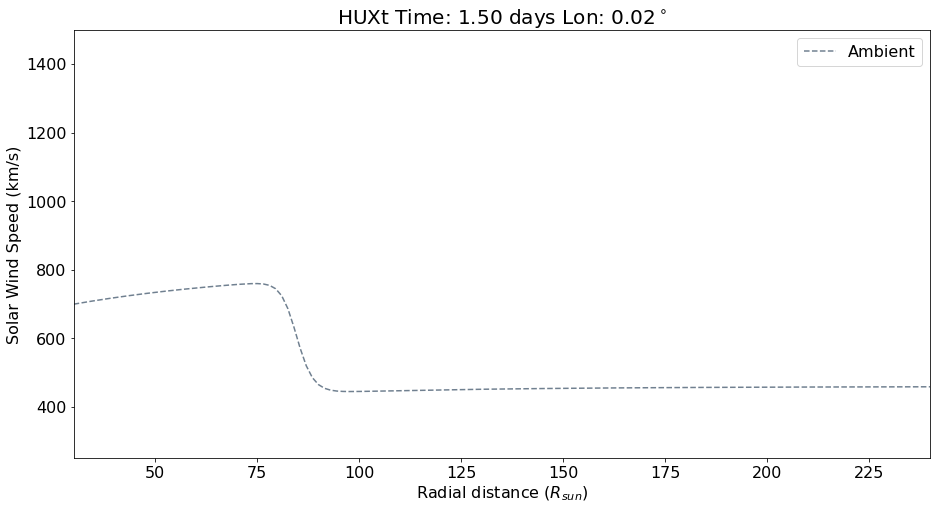

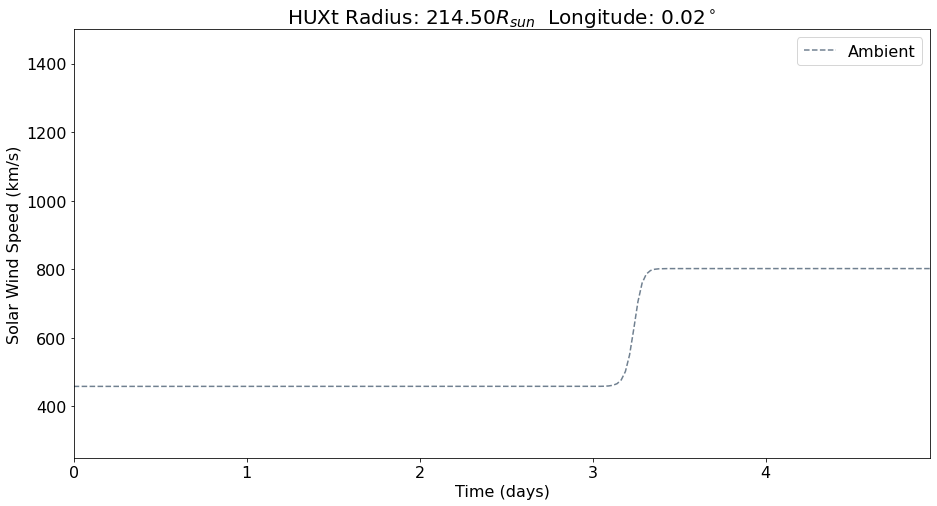

In [3]:
# Run HUXt in 1D (along one longitude) with user specified boundary conditions and no CMEs
#########################################################################################

#Form longitudinal boundary conditions - background wind of 400 km/s with two fast streams.
v_boundary = np.ones(128) * 400 * (u.km/u.s)
v_boundary[30:50] = 600 * (u.km/u.s)
v_boundary[95:125] = 700 * (u.km/u.s)

# This boundary condition looks like
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(v_boundary,'k-')
ax.set_xlabel('Longitude bin')
ax.set_ylabel('Input Wind Speed (km/s)')
ax.set_xlim(0,128)

# Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step), looking at 0 longitude
model = H.HUXt(v_boundary=v_boundary, lon_out=0.0*u.deg, simtime=5*u.day, dt_scale=4)

# Solve these conditions, with no ConeCMEs added.
cme_list = []
model.solve(cme_list)

# Plot the radial profile of the ambient wind profile at a fixed time (in days). 
t = 1.5*u.day
model.plot_radial(t, lon=0.0,field='ambient')

# Plot the time series of the ambient wind profile at a fixed radius. 
r = 1.0*u.AU
model.plot_timeseries(r,lon=0.0,field='ambient')

(<Figure size 1008x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c2025fd348>)

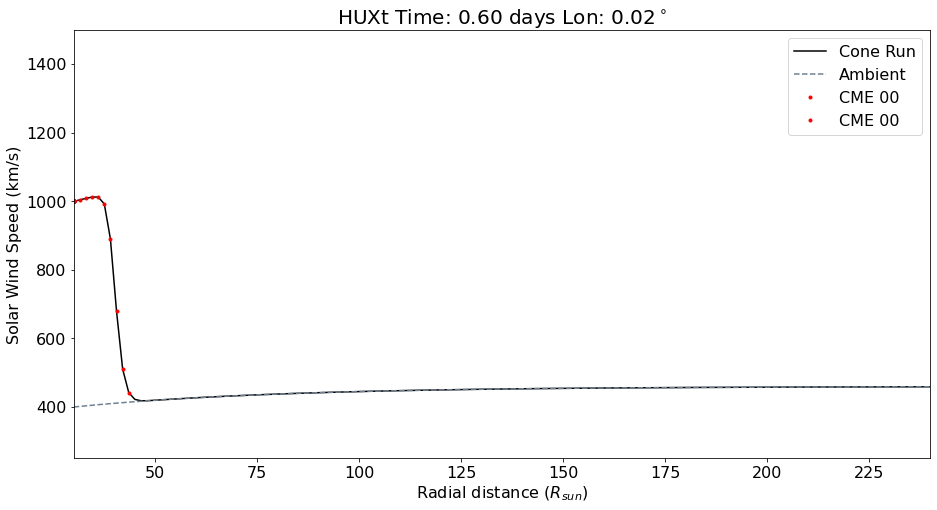

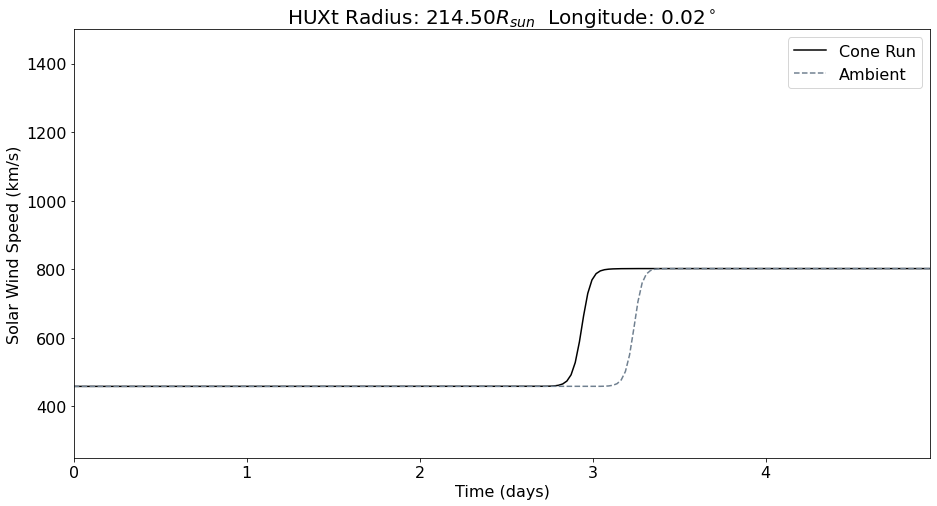

In [4]:
# Run HUXt in 1D (along one longitude) with user specified boundary conditions and single CME
############################################################################################

# Now lets run HUXt1D with the same background ambient wind and a cone cme.
# Launch the CME half a day after the simulation, at 0 longitude, 30 degree width, speed 850km/s and thickness=5 solar radii
cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=30*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
cme_list = [cme]

# Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step), looking at 0 longitude
model = H.HUXt(v_boundary=v_boundary, lon_out=0.0*u.deg, simtime=5*u.day, dt_scale=4)

# Run the model, and this time save the results to file.
model.solve(cme_list, save=True, tag='1d_conecme_test')

# Plot the radial profile and time series of both the ambient and ConeCME solutions at a fixed time (in days). 
# Save both to file as well. These are saved in HUXt>figures>HUXt1D
t = 0.6*u.day
model.plot_radial(t, lon=0.0*u.deg,field='both', save=True)
#model.plot_radial(t, field='both', save=True, tag='1d_cone_test_radial')

r = 1.0*u.AU
model.plot_timeseries(r, lon=0.0*u.deg,field='both', tag='1d_cone_test_radial')

(<Figure size 1008x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c202f099c8>)

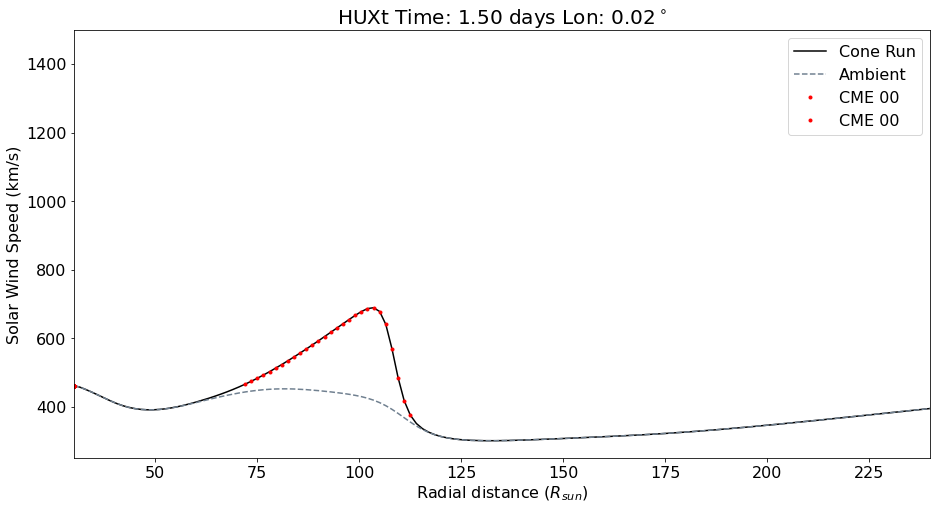

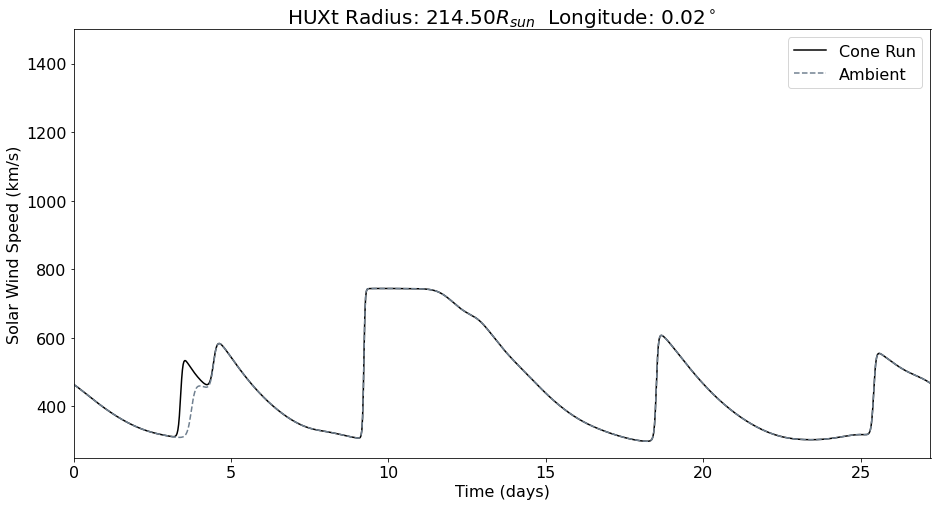

In [5]:
# Run HUXt with HelioMAS input
###############################################################################

#HUXt can be initiated with archived output from HelioMAS, by specifying a carrington rotation number
model = H.HUXt(cr_num=2124, lon_out=0.0*u.deg, simtime=27.27*u.day, dt_scale=4)

# Solve these conditions with a ConeCME.
cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=30*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
cme_list = [cme]
model.solve(cme_list)

# Plot the radial profile of the ambient wind solution at a fixed time (in days). 
t = 1.5*u.day
model.plot_radial(t, lon=0.0*u.deg,field='both',)

# Plot the time series of the ambient wind solution at a fixed radius. 
r = 1.0*u.AU
model.plot_timeseries(r, lon=0.0*u.deg,field='both')


(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x1c200ae3188>)

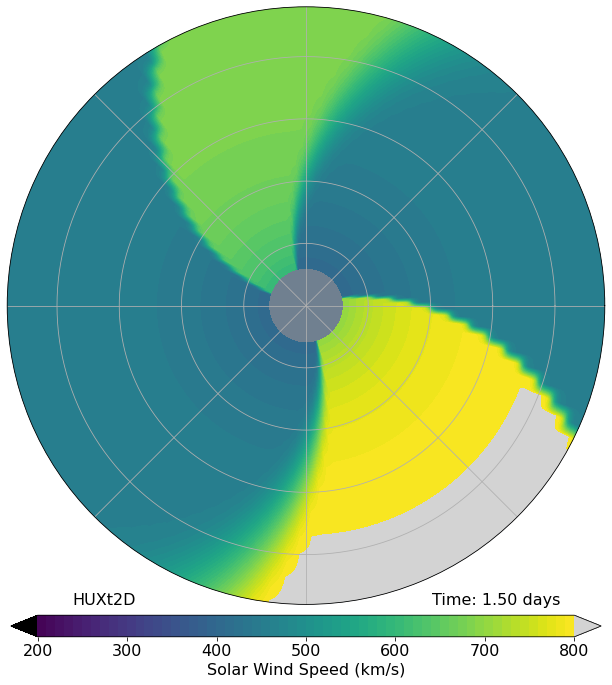

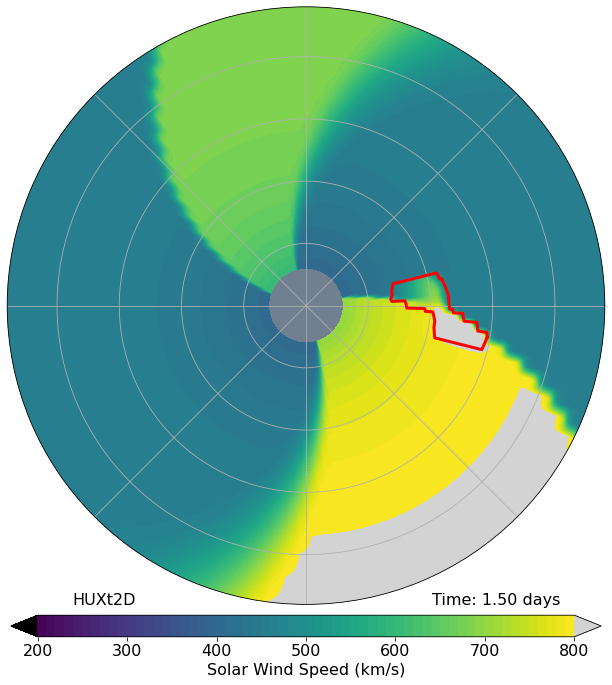

In [6]:
# Run HUXt at all longitudes with user specified boundary conditions and single CME
###############################################################################

#Form boundary conditions - background wind of 400 km/s with two fast streams.
v_boundary = np.ones(128) * 400 * (u.km/u.s)
v_boundary[30:50] = 600 * (u.km/u.s)
v_boundary[95:125] = 700 * (u.km/u.s)
#add a CME
cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=30*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
cme_list = [cme]

# Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step)
model = H.HUXt(v_boundary=v_boundary, simtime=5*u.day, dt_scale=4)

model.solve(cme_list)

t_interest = 1.5*u.day
model.plot(t_interest, field='ambient')
model.plot(t_interest, field='cme')

In [7]:
# Animate a MP4 of the CME solution. These are saved in HUXt>figures
###############################################################################
model.animate('cme', tag='cone_cme_test') # This takes about a minute too.


t:   0%|                                     | 0/240 [00:00<?, ?it/s, now=None]

Moviepy - Building video D:\Dropbox\python_repos\HUXt\figures\HUXt_CR9999_cone_cme_test_movie.mp4.
Moviepy - Writing video D:\Dropbox\python_repos\HUXt\figures\HUXt_CR9999_cone_cme_test_movie.mp4



Moviepy - Done !
Moviepy - video ready D:\Dropbox\python_repos\HUXt\figures\HUXt_CR9999_cone_cme_test_movie.mp4


In [8]:
# Model results can also be saved outside of the solve method.
###############################################################################
out_path = model.save(tag='cone_cme_test')

# And loaded back in with
model2, cme_list2 = H.load_HUXt_run(out_path)


Text(0, 0.5, 'Y ($R_{sun}$)')

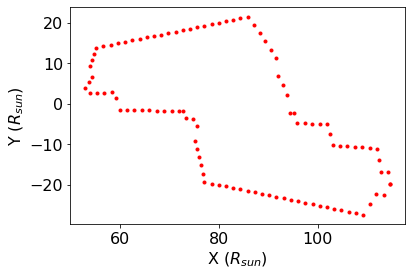

In [9]:
# Output the coordinates of the tracked CME boundary 
###############################################################################
cme = model2.cmes[0]
timestep = 50
rad = cme.coords[timestep]['r']
lon = cme.coords[timestep]['lon']
x = rad * np.cos(lon)
y = rad * np.sin(lon)

fig, ax = plt.subplots() # compare this with the boundary in the frame above.
ax.plot(x,y,'r.')
ax.set_xlabel('X ($R_{sun}$)')
ax.set_ylabel('Y ($R_{sun}$)')

In [10]:
# HUXt can be run with multiple ConeCMEs.
###############################################################################

# Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step), looking at 0 longitude
model = H.HUXt(cr_num=2100, simtime=5*u.day, dt_scale=4)

daysec = 86400
times = [0.5*daysec, 1.5*daysec, 3*daysec]
speeds = [850, 1000, 700]
lons = [0, 90, 300]
widths = [30, 40, 20]
thickness = [5, 4, 2]
cme_list = []
for t, l, w, v, thick in zip(times, lons, widths, speeds, thickness):
    cme = H.ConeCME(t_launch=t*u.s, longitude=l*u.deg, width=w*u.deg, v=v*model.kms, thickness=thick*u.solRad)
    cme_list.append(cme)

model.solve(cme_list, save=True, tag='multi_cones') # This takes a minute or so to run. 
model.animate('cme', tag='multi_cones')

t:   0%|                                     | 0/240 [00:00<?, ?it/s, now=None]

Moviepy - Building video D:\Dropbox\python_repos\HUXt\figures\HUXt_CR2100_multi_cones_movie.mp4.
Moviepy - Writing video D:\Dropbox\python_repos\HUXt\figures\HUXt_CR2100_multi_cones_movie.mp4



Moviepy - Done !
Moviepy - video ready D:\Dropbox\python_repos\HUXt\figures\HUXt_CR2100_multi_cones_movie.mp4


Help on Observer in module HUXt object:

class Observer(builtins.object)
 |  Observer(body, times)
 |  
 |  A class returning the HEEQ and Carrington coordinates of a specified Planet or spacecraft, for a given set of times.
 |  The positions are linearly interpolated from a 2-hour resolution ephemeris that spans 1974-01-01 until 2020-01-01.
 |  Allowed bodies are Earth, Venus, Mercury, STEREO-A and STEREO-B.
 |  Attributes:
 |      body: String name of the planet or spacecraft.
 |      lat: HEEQ latitude of body at all values of time.
 |      lat_c: Carrington latitude of body at all values of time.
 |      lon: HEEQ longitude of body at all values of time.
 |      lon_c: Carrington longitude of body at all values of time.
 |      r: HEEQ radius of body at all values of time.
 |      r_c: Carrington radius of body at all values of time.
 |      time: Array of Astropy Times
 |  
 |  Methods defined here:
 |  
 |  __init__(self, body, times)
 |      :param body: String indicating which 

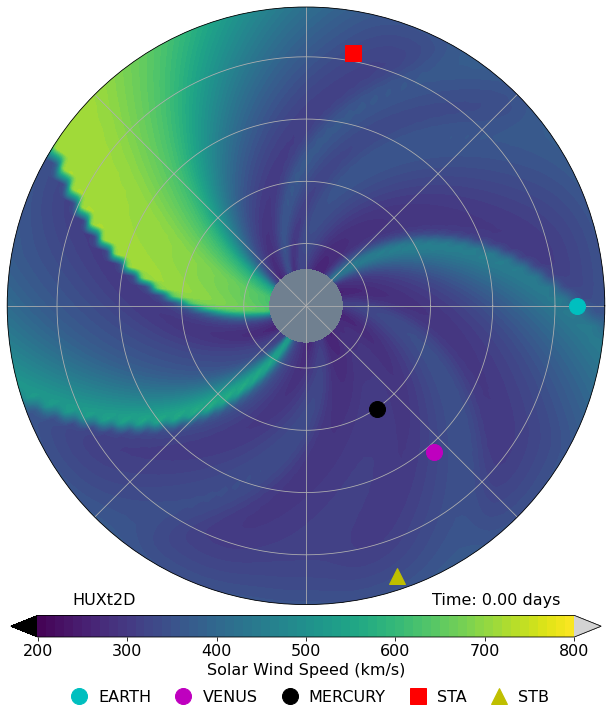

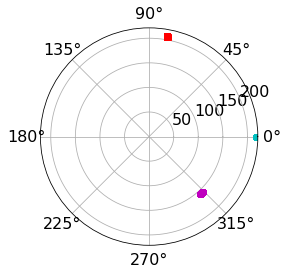

In [12]:
# There is also an ephemeris of the HEEQ and Carrington coordiates of Earth, Mercury, Venus, STEREO-A and STEREO-B
##################################################################################################################

# These are automatically plotted on model solutions derived from a particular Carrington rotation.
model.plot(model.time_out[0])

# You can retrieve a bodies position at each model timestep like:
earth = model.get_observer('earth')
sta = model.get_observer('sta')
venus = model.get_observer('venus')

# The bodies HEEQ and Carrington coordinates are attributes.
help(earth)

# So to plot them:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.plot(earth.lon, earth.r, 'co')
ax.plot(sta.lon, sta.r, 'rs')
ax.plot(venus.lon, venus.r, 'mo')

In [13]:
# HUXt can be run over a range of longitudes
############################################

# As HUXt is a purely radial model, it can be run over any set of longitudes. This could save disk-space and runtime if you are interested in large ensembles.
# This is done with the lon_start and lon_stop arguments.
model = H.HUXt(cr_num=2100, lon_start=300*u.deg, lon_stop=60*u.deg, simtime=5*u.day, dt_scale=4)

daysec = 86400
times = [0.5*daysec, 2*daysec]
speeds = [1000, 850]
lons = [-20, 20]
widths = [30, 30]
thickness = [8, 4]
cme_list = []
for t, l, w, v, thick in zip(times, lons, widths, speeds, thickness):
    cme = H.ConeCME(t_launch=t*u.s, longitude=l*u.deg, width=w*u.deg, v=v*model.kms, thickness=thick*u.solRad)
    cme_list.append(cme)

model.solve(cme_list, save=True, tag='multi_cones') # This takes a minute or so to run. 
model.animate('cme', tag='longitude_range')

t:   0%|                                     | 0/240 [00:00<?, ?it/s, now=None]

Moviepy - Building video D:\Dropbox\python_repos\HUXt\figures\HUXt_CR2100_longitude_range_movie.mp4.
Moviepy - Writing video D:\Dropbox\python_repos\HUXt\figures\HUXt_CR2100_longitude_range_movie.mp4



Moviepy - Done !
Moviepy - video ready D:\Dropbox\python_repos\HUXt\figures\HUXt_CR2100_longitude_range_movie.mp4


360.0 deg 2010-08-09T14:45:06.837
Warning, multiple matches found, selecting match with greatest target overlap
270.0 deg 2010-08-16T10:08:53.469
Warning, multiple matches found, selecting match with greatest target overlap
180.0 deg 2010-08-23T05:35:02.523


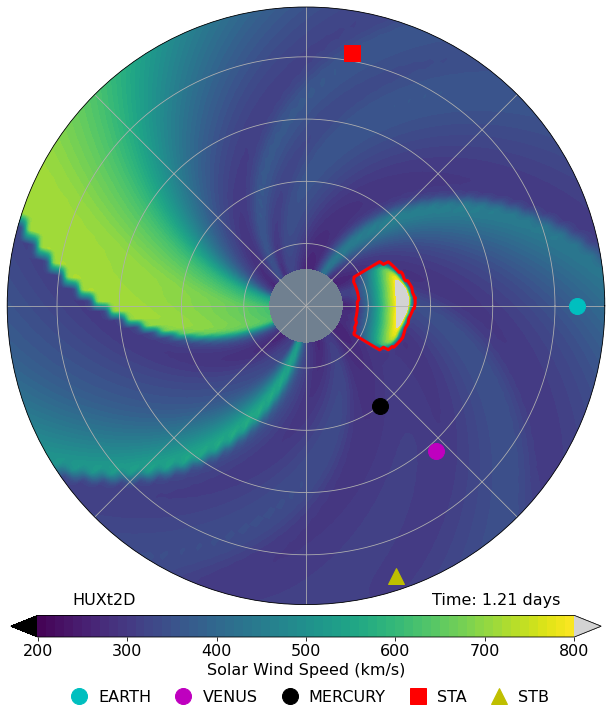

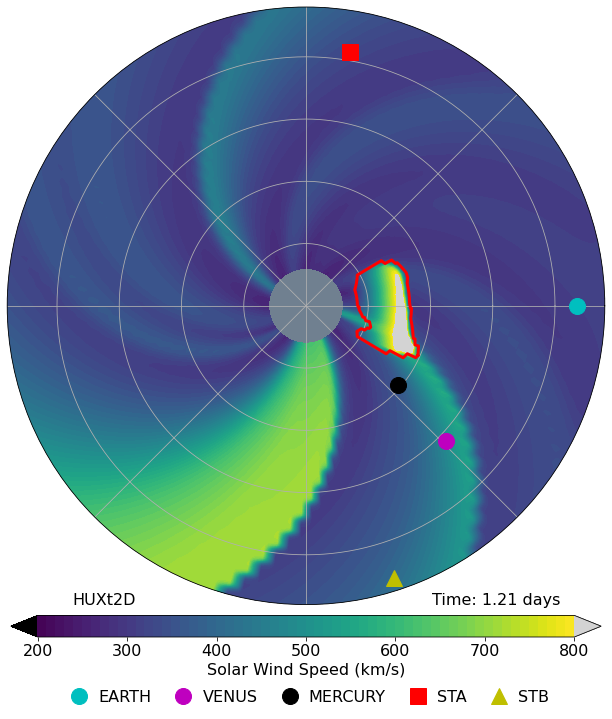

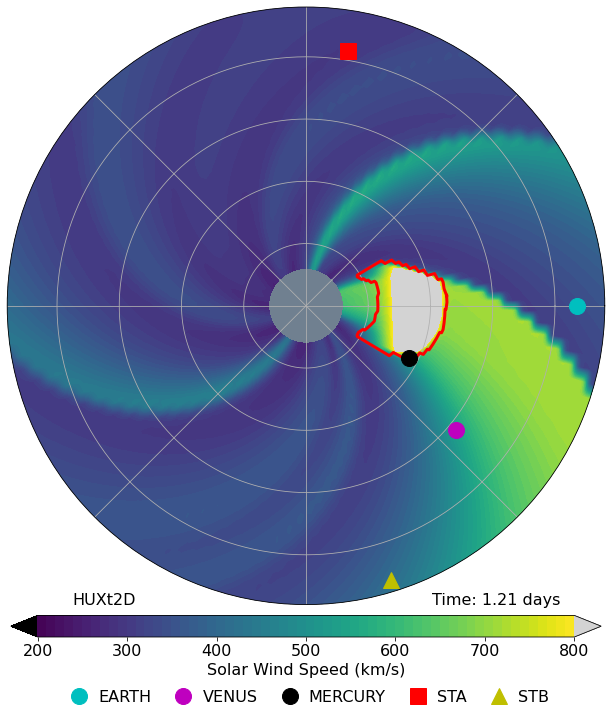

In [14]:
# Specifying the initial carrington longitude of Earth.
############################################

# With the cr_lon_init argument you can specify the initial carrington longitude of Earth at the models initialisation time.
# This sets the time_init attribute, so model times can be converted to UTC.
for cr_lon in [360, 270, 180]:
    model = H.HUXt(cr_num=2100, cr_lon_init=cr_lon*u.deg, simtime=5*u.day, dt_scale=4)
    cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=60*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
    model.solve([cme])
    cr_tag = 'cr_lon_{:03d}'.format(np.int32(cr_lon))
    model.plot(model.time_out[50], 'cme', save=True, tag=cr_tag)
    print(model.cr_lon_init.to('deg'), model.time_init.isot)
